# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [64]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

import pandas as pd
import numpy as np

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

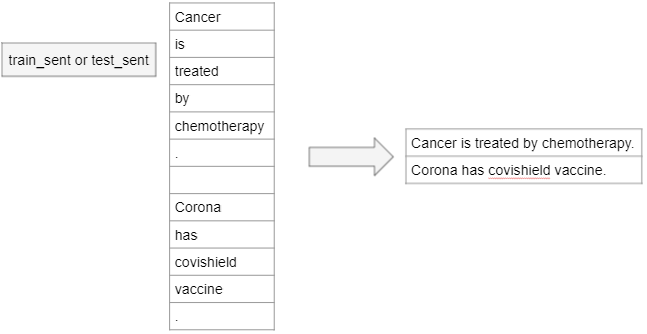

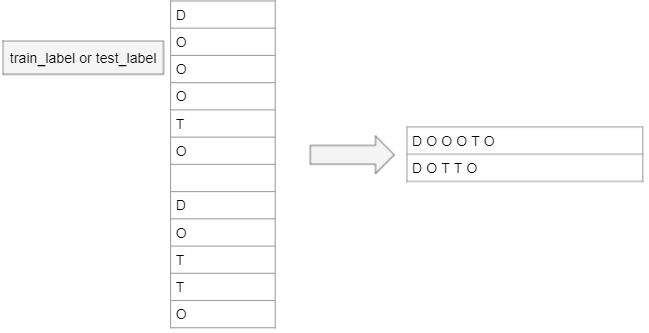

In [2]:
# read the data from files

with open('train_sent','r') as train_sent:
    train_sent = train_sent.readlines()
    
with open('test_sent', 'r') as test_sent:
    test_sent = test_sent.readlines()
    
with open('train_label', 'r') as train_label:
    train_label = train_label.readlines()
    
with open('test_label', 'r') as test_label:
    test_label = test_label.readlines()

In [3]:
# Function to convert given data to sentence formate

def sentenceFormat(data):
    final_list = []
    sub_list = []
    for word in data:
        word = word.rstrip('\n')    
        if(len(word) > 0):
            sub_list.append(word)
        else:
            final_list.append(' '.join(sub_list))
            sub_list = []
    return final_list

In [65]:
# Convert the data into sentence formate

train_sent_list = sentenceFormat(train_sent)
print(train_sent_list[110])
print('-'*100)

test_sent_list = sentenceFormat(test_sent)
print(test_sent_list[110])
print('-'*100)

train_label_list = sentenceFormat(train_label)
print(train_label_list[110])
print('-'*100)

test_label_list = sentenceFormat(test_label)
print(test_label_list[110])

Only 20 % had heard of a drug to reduce this risk , but 95 % would take such a therapy
----------------------------------------------------------------------------------------------------
Prevalence on the basis of enzyme immunoassay was 1.6 % ( 0.8 % to 2.7 % ) , with a sensitivity of 60 % and a specificity of 100 %
----------------------------------------------------------------------------------------------------
O O O O O O O O O O O O O O O O O O O O O
----------------------------------------------------------------------------------------------------
O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


In [5]:
# review the result

train_sent_list

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )",
 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age',
 'In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid 

### Count the number of sentences in the processed train and test dataset 

In [6]:
print(f'Lenght of train sentences : ' ,len(train_sent_list))
print(f'Lenght of test sentences : ' ,len(test_sent_list))


Lenght of train sentences :  2599
Lenght of test sentences :  1056


In [7]:
print(f'Lenght of train labels : ' ,len(train_label_list))
print(f'Lenght of test label : ' ,len(test_label_list))

Lenght of train labels :  2599
Lenght of test label :  1056


### Count the number of lines of labels in the processed train and test dataset.

##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [8]:
# Join all the record both training and test and provide to spacy model
complete_data = '. '.join(train_sent_list)+ '. ' + '. '.join(test_sent_list)


In [9]:
# create dictionary with list of words in LEMMA form with tag noun or propn

all_tokens = model(complete_data)
pos_dict = {}

for token in all_tokens:
    if(token.pos_ in ['NOUN','PROPN']):                      
        token_key = token.lemma_.lower() + '_' + token.pos_
        
        if(token_key in pos_dict.keys()):
            pos_dict[token_key] = pos_dict[token_key] + 1
        else:
            pos_dict[token_key] = 1
            
print(pos_dict)  
        

{'birth_NOUN': 10, 'week_NOUN': 48, 'university_PROPN': 6, 'vermont_PROPN': 1, 'delivery_NOUN': 23, 'route_NOUN': 3, 'indication_NOUN': 6, 'age_NOUN': 61, 'parity_NOUN': 4, 'practice_NOUN': 48, 'group_NOUN': 128, 'risk_NOUN': 78, 'status_NOUN': 17, 'rate_NOUN': 103, '%_NOUN': 247, 'presentation_NOUN': 9, 'medicine_NOUN': 37, 'patient_NOUN': 568, 'arrest_NOUN': 6, 'dilation_NOUN': 4, 'subgroup_NOUN': 6, 'care_NOUN': 56, 'hospital_NOUN': 31, 'community_NOUN': 16, 'trimester_NOUN': 4, 'fluid_NOUN': 9, 'index_NOUN': 16, 'afi_PROPN': 8, 'temperature_NOUN': 11, 'increase_NOUN': 32, 'decrease_NOUN': 7, 'june_PROPN': 2, 'august_PROPN': 6, 'period_NOUN': 30, 'heat_NOUN': 5, 'woman_NOUN': 89, 'singleton_NOUN': 1, 'pregnancy_NOUN': 46, 'gestation_NOUN': 9, 'testing_NOUN': 25, 'determination_NOUN': 8, 'ambient_NOUN': 1, 'area_NOUN': 15, 'day_NOUN': 63, 'mean_NOUN': 6, 'test_NOUN': 34, 'date_NOUN': 3, 'spearman_PROPN': 1, 'rank_NOUN': 2, 'correlation_PROPN': 1, 'relationship_NOUN': 18, 'account_NOU

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [30]:
pos_df = pd.DataFrame({'word_lemma_pos_tag': pos_dict.keys() , 'count' : pos_dict.values()})

In [31]:
pos_df.sort_values('count',ascending=False).head(25)

,word_lemma_pos_tag,count
17,patient_NOUN,568
64,treatment_NOUN,314
14,%_NOUN,247
55,study_NOUN,222
268,cancer_NOUN,219
991,cell_NOUN,202
403,therapy_NOUN,182
331,effect_NOUN,180
191,disease_NOUN,162
74,case_NOUN,131


## Defining features for CRF





In [12]:
# Let's define the features to get the feature value for one word.

def getFeatureValuesOneWord(sentence,loc,tokens):
    word = sentence[loc]
    pos_tag = tokens[loc].pos_
    features = [
        'word.lower = ' + word.lower(),
        f"word.isnounpropn={pos_tag in ['NOUN', 'PROPN']}",# is noun or propn
        'word[-3] = ' + word[-3:],
        'word[-2] = ' + word[-2:],
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
    ]
    
    if(loc>0):
        prev_word = sentence[loc-1]
        prev_pos_tag = tokens[loc-1].pos_
        features.extend([
        'prev_word.lower = ' + prev_word.lower(),
        f"prev_word.isnounpropn={prev_pos_tag in ['NOUN', 'PROPN']}" ,# is noun or propn
        'prev_word[-3] = ' + prev_word[-3:],
        'prev_word[-2] = ' + prev_word[-2:],
        'prev_word.isupper=%s' % prev_word.isupper(),  # is the word in all uppercase
        'prev_word.isdigit=%s' % prev_word.isdigit(),  # is the word a number
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper() # is the word starting with a capital letter
        ])
    else:
        features.append('BEG')
    
    if(loc == len(sentence) - 1):
        features.append('END')
        
    return features
    
    
    

## Getting the features

### Write a code/function to get the features for a sentence

In [13]:
# Funtion to create the features for given sentence

train_tokens = model(train_sent_list[0])

def getFeatureValuesOneSentence(data,index):
    sentence = data[index]
    sentence_list = sentence.split()
    tokens = model(sentence)    
    features = [getFeatureValuesOneWord(sentence_list,loc,tokens) for loc in range(len(sentence_list))]
    return features

def getFeaturesAll(data):
    features = [getFeatureValuesOneSentence(data,index) for index in range(len(data))]
    return features

In [14]:
# get the feature for one sentence
getFeatureValuesOneSentence(train_sent_list,1)

[['word.lower = the',
  'word.isnounpropn=False',
  'word[-3] = The',
  'word[-2] = he',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=True',
  'BEG'],
 ['word.lower = total',
  'word.isnounpropn=False',
  'word[-3] = tal',
  'word[-2] = al',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'prev_word.lower = the',
  'prev_word.isnounpropn=False',
  'prev_word[-3] = The',
  'prev_word[-2] = he',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=True'],
 ['word.lower = cesarean',
  'word.isnounpropn=False',
  'word[-3] = ean',
  'word[-2] = an',
  'word.isupper=False',
  'word.isdigit=False',
  'words.startsWithCapital=False',
  'prev_word.lower = total',
  'prev_word.isnounpropn=False',
  'prev_word[-3] = tal',
  'prev_word[-2] = al',
  'prev_word.isupper=False',
  'prev_word.isdigit=False',
  'prev_word.startsWithCapital=False'],
 ['word.lower = rate',
  'word.isnounpropn=True',
  '

### Write a code/function to get the labels of a sentence

In [15]:
# function to get labels of a given sentence
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [16]:
X_train = [getFeatureValuesOneSentence(train_sent_list,index) for index in range(len(train_label_list))]
X_test = [getFeatureValuesOneSentence(test_sent_list,index) for index in range(len(test_label_list))]

In [17]:
print(len(X_train),len(X_test))

2599 1056


### Define the labels as the target variable for test and the train dataset

In [18]:
y_train = [getLabelsInListForOneSentence(labels) for labels in train_label_list]
y_test = [getLabelsInListForOneSentence(labels) for labels in test_label_list]

In [19]:
print(len(y_train),len(y_test))

2599 1056


## Build the CRF Model

In [20]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

In [21]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass



## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [22]:
y_pred = crf.predict(X_test)

In [23]:
print("Actual labels for record 111: ")
print(y_test[111])
print('-'*100)
print("Predicted labels for record 111: ")
print(str(y_pred[111]))


Actual labels for record 111: 
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
----------------------------------------------------------------------------------------------------
Predicted labels for record 111: 
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D']


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [24]:
metrics.flat_f1_score(y_test,y_pred,average = 'weighted')

0.9038120848915069

### Got f1 score of about 90.4% which is a good score. But this can improved by providing some more features to crf model.

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

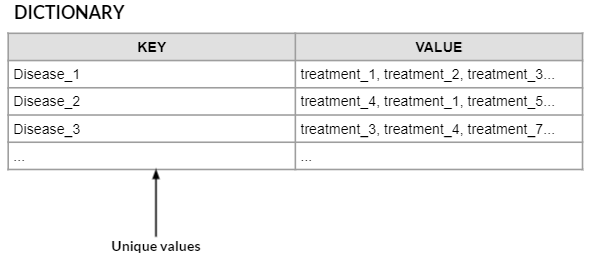

In [25]:
import re
def fetch_diseases(sentence,preds):
    matches = re.finditer(r'D+',''.join(preds))
    allDiseaseInOneRecord = []
    for match in matches:
        start = match.start()
        end = match.end()        
        disease = ' '.join(sentence.split()[start:end])
        allDiseaseInOneRecord.append(disease.lower())
    return allDiseaseInOneRecord

def fetch_treatments(sentence,preds):
    matches = re.finditer(r'T+',''.join(preds))
    allTreatmentsInOneRecord = []
    for match in matches:
        start = match.start()
        end = match.end()        
        disease = ' '.join(sentence.split()[start:end])
        allTreatmentsInOneRecord.append(disease.lower())
    return allTreatmentsInOneRecord

In [41]:
disease_treatment= {}

for i,preds in enumerate(y_pred): 
    
    allDiseaseInOneRecord = ''
    allTreatmentsInOneRecord = ''
        
    if('D' in preds):
        allDiseaseInOneRecord = fetch_diseases(test_sent_list[i],preds)
    if('T' in preds):        
        allTreatmentsInOneRecord = fetch_treatments(test_sent_list[i],preds)
    
    if(len(allDiseaseInOneRecord) > 0):
        for disease in allDiseaseInOneRecord:
            if(disease in disease_treatment.keys()):
                if(len(allTreatmentsInOneRecord) > 0):
                    disease_treatment[disease] = disease_treatment[disease] + ' , ' + ' '.join(allTreatmentsInOneRecord)
            else:
                if(len(allTreatmentsInOneRecord) > 0):
                    disease_treatment[disease] = ' '.join(allTreatmentsInOneRecord)
                
print(disease_treatment)             

{'hereditary retinoblastoma': 'radiotherapy', 'unstable angina or non-q-wave myocardial infarction': 'roxithromycin', 'pulmonary hypertension': 'fenfluramines', 'essential hypertension': 'moxonidine', 'cellulitis': 'g-csf therapy intravenous antibiotic treatment', 'cardiac disease': 'fenfluramine-phentermine', "early parkinson 's disease": 'ropinirole monotherapy', 'exclude abdominal tuberculosis': 'steroids', "crohn 's disease": 'steroids', 'female stress urinary incontinence': 'surgical treatment', 'stress urinary incontinence': 'therapy', 'preeclampsia': 'intrauterine insemination with donor sperm versus intrauterine insemination', 'severe acquired hyperammonemia': 'organ transplantation and chemotherapy', 'cancer': 'organ transplantation and chemotherapy , immunotherapy , oral drugs chemotherapy , matrix metalloproteinase inhibitors', 'major pulmonary embolism': 'thrombolytic treatment', 'malignant pleural mesothelioma': 'thoracotomy , radiotherapy , and chemotherapy', 'tumor marke

In [55]:
disease_treatment_df = pd.DataFrame({'Disease' : disease_treatment.keys(),'Treatment': disease_treatment.values()})
disease_treatment_df = disease_treatment_df.set_index('Disease')

### Dictionary of Disease and its treatment

In [56]:
disease_treatment_df.head()

,Treatment
Disease,
hereditary retinoblastoma,radiotherapy
unstable angina or non-q-wave myocardial infarction,roxithromycin
pulmonary hypertension,fenfluramines
essential hypertension,moxonidine
cellulitis,g-csf therapy intravenous antibiotic treatment


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [63]:
disease_treatment['hereditary retinoblastoma']


'radiotherapy'